# Attention Class
taken from https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Preprocessing And Exploration

In [ ]:
!pip install pyarrow==0.16.0
!pip install nlp
import nlp
dataset = nlp.load_dataset('gigaword')

Using custom data configuration default


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') #just for the sake of better visibility

Using TensorFlow backend.


In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset

{'test': Dataset(schema: {'document': 'string', 'summary': 'string'}, num_rows: 1951),
 'train': Dataset(schema: {'document': 'string', 'summary': 'string'}, num_rows: 3803957),
 'validation': Dataset(schema: {'document': 'string', 'summary': 'string'}, num_rows: 189651)}

In [ ]:
train_data = dataset['train'][:70000]

In [ ]:
data = pd.DataFrame(columns=['Text'])

In [ ]:
data['Text'] = train_data['document']
data['Summary'] = train_data['summary']

In [ ]:
data.head(10)

,Text,Summary
0,australia 's current account deficit shrunk by...,australian current account deficit narrows sha...
1,at least two people were killed in a suspected...,at least two dead in southern philippines blast
2,australian shares closed down #.# percent mond...,australian stocks close down #.# percent
3,south korea 's nuclear envoy kim sook urged no...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy
5,taiwan share prices closed down #.## percent m...,taiwan shares close down #.## percent
6,australian shares closed down #.# percent mond...,australian stocks close down #.# percent
7,"spanish property group colonial , struggling u...",spain 's colonial posts #.## billion euro loss
8,libyan leader moamer kadhafi monday promised w...,kadhafi promises wide political economic reforms
9,the united nations ' humanitarian chief john h...,un 's top aid official arrives in drought-hit ...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     70000 non-null  object
 1   Summary  70000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
print('Duplicate rows : ',len(data)-len(data.drop_duplicates())) #checking number of duplicate rows

Duplicate rows :  2777


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
print("Rows with NA values : ",len(data)-len(data.dropna()))
data.dropna(axis=0,inplace=True)
print('Total Rows After droping rows with NA values: ',len(data))

Rows with NA values :  0
Total Rows After droping rows with NA values:  67223


In [ ]:
data.head()

,Text,Summary
0,australia 's current account deficit shrunk by...,australian current account deficit narrows sha...
1,at least two people were killed in a suspected...,at least two dead in southern philippines blast
2,australian shares closed down #.# percent mond...,australian stocks close down #.# percent
3,south korea 's nuclear envoy kim sook urged no...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy


In [ ]:
contraction_mapping = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he has",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower() #lower all
    newString = BeautifulSoup(newString, "lxml").text #remove hyperlinks
    newString = re.sub(r'\([^)]*\)', '', newString) #replacing bracketed words like also known as(a.k.a) with also known as
    newString = re.sub('"','', newString) #removing quotation marks
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    #expanding the contractions
    newString = re.sub(r"'s\b","",newString) #remove blank spaces
    newString = re.sub("[^a-zA-Z]", " ", newString) #remove all non alphabetic characters FOR the time being would not remove while using pointer generator networks
    tokens = [w for w in newString.split() if not w in stop_words] #removing stopwords
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short word with len equal to 1
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)#removing quotation marks
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])     #expanding the contractions
    newString = re.sub(r"'s\b","",newString)  #remove blank spaces
    newString = re.sub("[^a-zA-Z]", " ", newString)#remove all non alphabetic characters
    newString = newString.lower() #lower everything
    tokens=newString.split() #generating tokens here we didnot removed the stopwords because they seem right in summary
    words=[]
    for t in tokens:                                                 #removing short word
          words.append(t)   
    return (" ".join(words)).strip()

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.head(10)

,Text,Summary,cleaned_text,cleaned_summary
0,australia 's current account deficit shrunk by...,australian current account deficit narrows sha...,australia current account deficit shrunk recor...,australian current account deficit narrows sha...
1,at least two people were killed in a suspected...,at least two dead in southern philippines blast,least two people killed suspected bomb attack ...,at least two dead in southern philippines blast
2,australian shares closed down #.# percent mond...,australian stocks close down #.# percent,australian shares closed percent monday follow...,australian stocks close down percent
3,south korea 's nuclear envoy kim sook urged no...,envoy urges north korea to restart nuclear dis...,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy,south korea monday announced sweeping tax refo...,skorea announces tax cuts to stimulate economy
5,taiwan share prices closed down #.## percent m...,taiwan shares close down #.## percent,taiwan share prices closed percent monday wall...,taiwan shares close down percent
7,"spanish property group colonial , struggling u...",spain 's colonial posts #.## billion euro loss,spanish property group colonial struggling hug...,spain colonial posts billion euro loss
8,libyan leader moamer kadhafi monday promised w...,kadhafi promises wide political economic reforms,libyan leader moamer kadhafi monday promised w...,kadhafi promises wide political economic reforms
9,the united nations ' humanitarian chief john h...,un 's top aid official arrives in drought-hit ...,united nations humanitarian chief john holmes ...,un top aid official arrives in drought hit eth...
10,new zealand share prices closed #.## percent h...,new zealand stocks close #.## percent higher,new zealand share prices closed percent higher...,new zealand stocks close percent higher


In [ ]:
f = lambda x : len(x.split(" "))
print('Max Document length in corpus : ',max(data['cleaned_text'].apply(f).to_list()))
print('Max Summary length in corpus : ',max(data['cleaned_summary'].apply(f).to_list()))

Max Document length in corpus :  49
Max Summary length in corpus :  27


In [ ]:
document = data['cleaned_text']
summary = data['cleaned_summary']

In [ ]:
document[5],summary[5]

('taiwan share prices closed percent monday wall street weakness lacklustre interim earnings electronics manufacturing giant hon hai dealers said',
 'taiwan shares close down percent')

In [ ]:
document_lengths = pd.Series([len(x.split(" ")) for x in document])
summary_lengths = pd.Series([len(x.split(" ")) for x in summary])

In [ ]:
document_lengths.describe() #to find the mean length of text sentences

count    67223.000000
mean        19.222126
std          3.759461
min          3.000000
25%         17.000000
50%         19.000000
75%         22.000000
max         49.000000
dtype: float64

In [ ]:
summary_lengths.describe() #to find the mean length of summary sentences

count    67223.000000
mean         8.059667
std          1.984205
min          3.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         27.000000
dtype: float64

In [ ]:
#based on above stats of length of document and its summary (keep mean value along with possible variance)
max_text_len=64
max_summary_len=32

In [ ]:
#Taking only the sentences whose summary length and text length are in our limits because that is only relevant
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df.head()

,text,summary
0,australia current account deficit shrunk recor...,australian current account deficit narrows sha...
1,least two people killed suspected bomb attack ...,at least two dead in southern philippines blast
2,australian shares closed percent monday follow...,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north...,envoy urges north korea to restart nuclear dis...
4,south korea monday announced sweeping tax refo...,skorea announces tax cuts to stimulate economy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67223 entries, 0 to 67222
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     67223 non-null  object
 1   summary  67223 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [ ]:
df['summary'] = df['summary'].apply(lambda x : '<start> '+ x + ' <end>') #appending Start of Sentences and End of sentence tokens

In [ ]:
df.head(10)

,text,summary
0,australia current account deficit shrunk recor...,<start> australian current account deficit nar...
1,least two people killed suspected bomb attack ...,<start> at least two dead in southern philippi...
2,australian shares closed percent monday follow...,<start> australian stocks close down percent <...
3,south korea nuclear envoy kim sook urged north...,<start> envoy urges north korea to restart nuc...
4,south korea monday announced sweeping tax refo...,<start> skorea announces tax cuts to stimulate...
5,taiwan share prices closed percent monday wall...,<start> taiwan shares close down percent <end>
6,spanish property group colonial struggling hug...,<start> spain colonial posts billion euro loss...
7,libyan leader moamer kadhafi monday promised w...,<start> kadhafi promises wide political econom...
8,united nations humanitarian chief john holmes ...,<start> un top aid official arrives in drought...
9,new zealand share prices closed percent higher...,<start> new zealand stocks close percent highe...


In [ ]:
#Finally taking a lool at preprocessed Reviews and their summaries
for i in range(10,20):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: beijing enjoying best air quality decade thanks steps taken olympics authorities said monday amid push locals anti pollution measures made permanent
Summary: <start> beijing best air in a decade due to olympic measures <end>


Review: south korean shares closed percent lower monday following steep losses wall street continued decline dollar analysts said
Summary: <start> skorean stocks close percent lower <end>


Review: south korea state run korea development bank refused comment monday british newspaper report still seeking stake troubled us investment bank lehman brothers
Summary: <start> skorea bank refuses to confirm reported talks with lehman <end>


Review: taiwan shares closed percent monday wall street weakness lacklustre interim earnings electronics manufacturing giant hon hai dealers said
Summary: <start> taiwan shares close down percent <end>


Review: south korea inflation rate slowed slightly august oil commodity prices showed signs stabilising national statistica

In [ ]:
#Spliting into training and validation sets
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=42,shuffle=True)

In [ ]:
print(x_tr.shape,y_tr.shape,sep='\n')

(53778,)
(53778,)


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='UNK')
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print(f'total words : {tot_cnt}')
print(f'rare words : {cnt}')   
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

total words : 34220
rare words : 19204
% of rare words in vocabulary: 56.11922852133255
Total Coverage of rare words: 2.857496600060744


In [ ]:
#prepare a tokenizer for reviews on training data neglecting rare words as their coverage over total document is very less
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='UNK') 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

15017

In [ ]:
x_tr.shape , type(x_tr) , x_val.shape , type(x_val) , x_voc

((53778, 64), numpy.ndarray, (13445, 64), numpy.ndarray, 15017)

##Summary Vocab

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='UNK')   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=2 
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print(f'total words : {tot_cnt}')
print(f'rare words : {cnt}')   
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

total words : 20731
rare words : 7309
% of rare words in vocabulary: 35.256379335294966
Total Coverage of rare words: 1.351069080315502


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='UNK') 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

13423

In [ ]:
y_tr.shape , type(y_tr) , y_val.shape , type(y_val) , y_voc

((53778, 32), numpy.ndarray, (13445, 32), numpy.ndarray, 13423)

In [ ]:
y_tr[0]

array([   2, 4164, 3557,  303,    7,  641, 2626,  169,    8,   30,  118,
          3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
y_tokenizer.sequences_to_texts([y_tr[0]])

['<start> skandia shareholder support for old mutual bid on the rise <end> UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK']

In [ ]:
y_tokenizer.word_counts['<start>'],len(y_tr)  

(53778, 53778)

In [ ]:
#removing sentences (text+summary obviously) containing just the start and end tokens from training data
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
#removing sentences (text+summary obviously) containing just the start and end tokens from validation data
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
x_tr.shape,y_tr.shape

((53778, 64), (53778, 32))

In [ ]:
x_val.shape,y_val.shape

((13445, 64), (13445, 32))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 768)      11533056    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64, 300), (N 1282800     embedding[0][0]                  
_____________________________________________________________________________________________

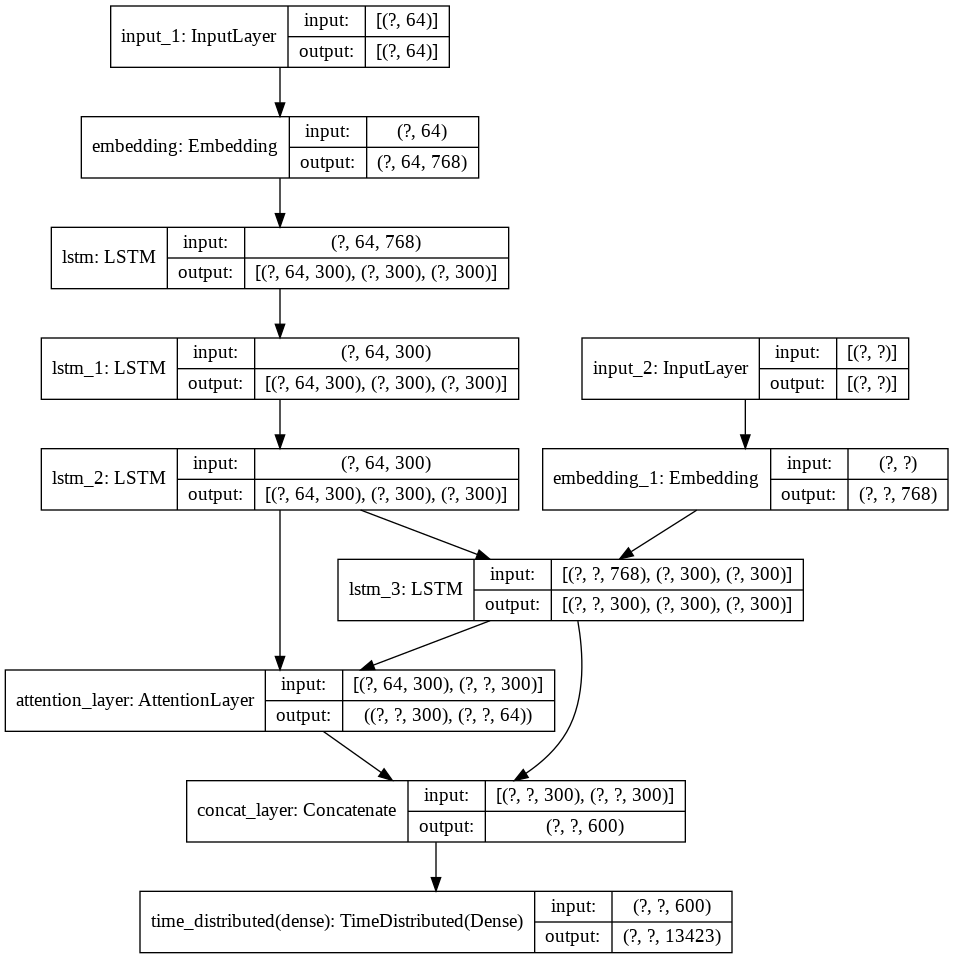

In [ ]:
from keras import backend as K 
K.clear_session()
latent_dim = 300
embedding_dim= 768

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/MinorProject/modelPlot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2,verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 53778 samples, validate on 13445 samples
Epoch 1/10
53778/53778 [==============================] - 643s 12ms/sample - loss: 1.8582 - acc: 0.7540 - val_loss: 1.6509 - val_acc: 0.7672
Epoch 2/10
53778/53778 [==============================] - 637s 12ms/sample - loss: 1.6115 - acc: 0.7731 - val_loss: 1.5355 - val_acc: 0.7794
Epoch 3/10
53778/53778 [==============================] - 630s 12ms/sample - loss: 1.5090 - acc: 0.7831 - val_loss: 1.4649 - val_acc: 0.7863
Epoch 4/10
53778/53778 [==============================] - 627s 12ms/sample - loss: 1.4354 - acc: 0.7903 - val_loss: 1.4144 - val_acc: 0.7917
Epoch 5/10
53778/53778 [==============================] - 626s 12ms/sample - loss: 1.3800 - acc: 0.7961 - val_loss: 1.3813 - val_acc: 0.7951
Epoch 6/10
53778/53778 [==============================] - 625s 12ms/sample - loss: 1.3317 - acc: 0.8006 - val_loss: 1.3496 - val_acc: 0.7984
Epoch 7/10

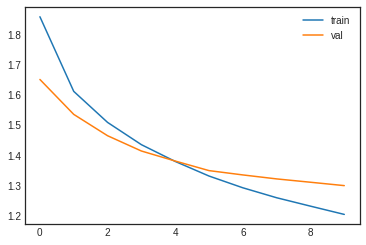

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val') 
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
len(reverse_target_word_index)

20732

In [ ]:
len(reverse_source_word_index) 

34221

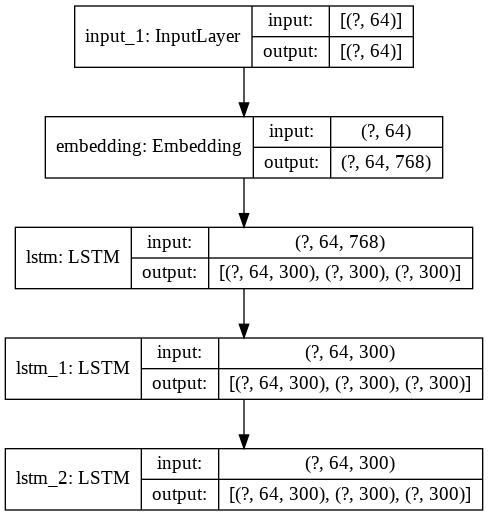

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


from tensorflow.keras.utils import plot_model
plot_model(encoder_model, to_file='/content/drive/My Drive/MinorProject/Inf_Enc_modelPlot.png', show_shapes=True, show_layer_names=True)

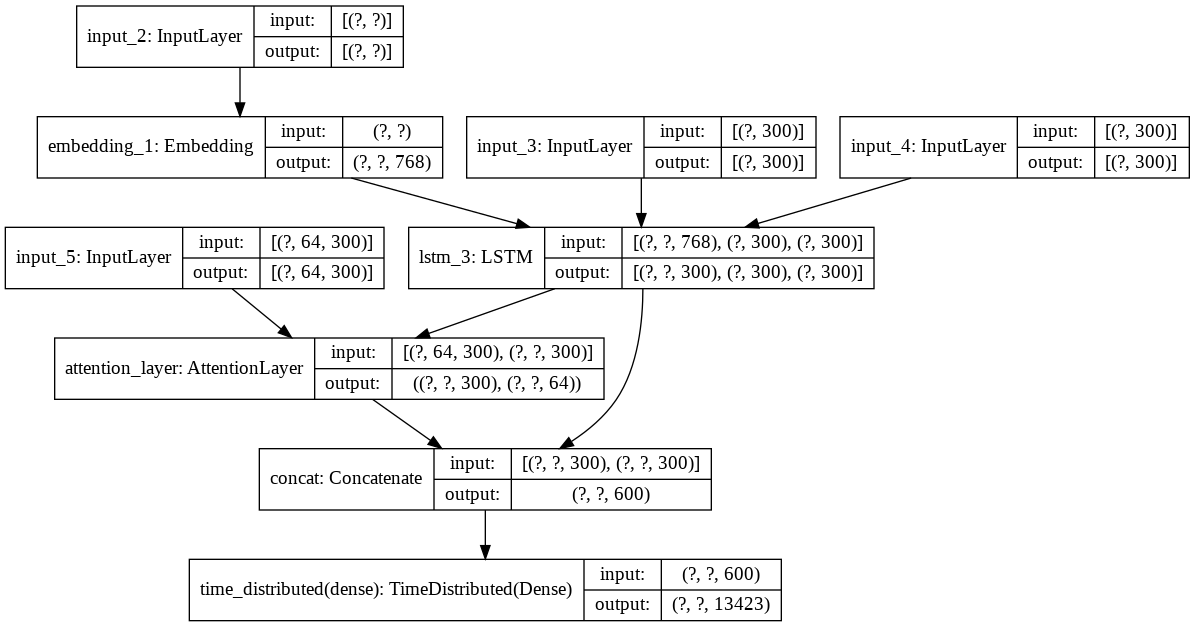

In [ ]:
plot_model(decoder_model, to_file='/content/drive/My Drive/MinorProject/Inf_Dec_modelPlot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<end>'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<end>'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['<start>']) and i!=target_word_index['<end>']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
seq2summary(y_val[0])

'israeli soldiers wounded in south lebanon '

In [ ]:
for i in range(500,600):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: us shares staged modest recovery tuesday despite underlying investors jitters lifted bargain hunting steep declines past three sessions 
Original summary: stocks get modest bounce dow back above 
Predicted summary:  wall street rebounds from dow up percent


Review: juventus coach <UNK> <UNK> refused <UNK> defeat italian title race team potentially damaging loss parma 
Original summary: no surrender vows lippi after parma defeat 
Predicted summary:  UNK wins tour of italy


Review: dollar edged higher wednesday major currencies market players took optimistic outlook vital us economic data due later week 
Original summary: dollar higher on favorable us economic data 
Predicted summary:  dollar gold falls slightly


Review: head world body regulating trade endangered animals warned system complicated making difficult police multi billion dollar wildlife industry 
Original summary: head of wildlife trade body warns of dense rules 
Predicted summary:  world trade warns of more atta